<div class="alert alert-block alert-info">

----------
---------
# <b> 1. Imports</b> 

--------------
----------------
</div>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import os, csv, matplotlib.pyplot as plt


/home/javid/corrosion-detector/AP/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<div class="alert alert-block alert-info">

----------
---------
# <b> 2. Configuration & Paths</b> 

--------------
----------------
</div>

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


# Paths 

ROOT = "../data"

# The following absolute path was used on the HPC server and is kept here
# only for reference. It is NOT required to run this notebook locally.
# ROOT = "/home/javid/segmentation_resnet/data"

TRAIN_LIST = os.path.join(ROOT, "train.txt")
VAL_LIST   = os.path.join(ROOT, "val.txt")
TEST_LIST  = os.path.join(ROOT, "test.txt")

IMG_SIZE = 512
BATCH_SIZE = 4
EPOCHS = 25
LR = 5e-5
NUM_WORKERS = 4


Using device: cuda


<div class="alert alert-block alert-info">

----------
---------
# <b> 3. Model and Image Processor</b> 

--------------
----------------
</div>

In [ ]:
processor = SegformerImageProcessor( # Image processor
    do_resize=True,
    size={"height": 512, "width": 512},
    resample=Image.BILINEAR,
    do_normalize=True
)

model = SegformerForSemanticSegmentation.from_pretrained( # Model
    num_labels=1,
    ignore_mismatched_sizes=True
).to(DEVICE)

print("Loaded SegFormer-B2")

# The warning about newly initialized weights is expected.
# The pretrained checkpoint uses 150 classes (ADE20K),
# while this project performs binary segmentation (1 class).

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([1, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded SegFormer-B2


<div class="alert alert-block alert-info">

----------
---------
# <b> 4. Dataset Definition</b> 

--------------
----------------
</div>

In [ ]:
class SegFormerDataset(Dataset):
    def __init__(self, list_path):
        with open(list_path, "r") as f:
            self.items = [line.strip().split() for line in f.readlines()]

        self.mask_resize = transforms.Resize((512, 512), interpolation=Image.NEAREST)

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img_path, mask_path = self.items[idx]

        image = Image.open(img_path).convert("RGB")

        mask = Image.open(mask_path).convert("L")
        mask = self.mask_resize(mask)              
        mask = (np.array(mask) > 127).astype(np.float32)
        mask = torch.tensor(mask).unsqueeze(0)     

        encoded = processor(images=image, return_tensors="pt")
        img_tensor = encoded["pixel_values"].squeeze(0)  

        return img_tensor, mask


<div class="alert alert-block alert-info">

----------
---------
# <b> 5. DataLoader Setup</b> 

--------------
----------------
</div>

In [ ]:
train_dataset = SegFormerDataset(TRAIN_LIST) # Creating dataset objects for training, validation, and testing
val_dataset   = SegFormerDataset(VAL_LIST)
test_dataset  = SegFormerDataset(TEST_LIST)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)# Initializing DataLoaders for efficient batch processing
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=NUM_WORKERS)

print("Train:", len(train_dataset)) # Printing dataset sizes for verification
print("Val:", len(val_dataset))
print("Test:", len(test_dataset))


Train: 571
Val: 122
Test: 123


<div class="alert alert-block alert-info">

----------
---------
# <b> 6. Loss Functions</b> 

--------------
----------------
</div>

In [6]:
bce_loss = nn.BCEWithLogitsLoss()

def dice_loss(pred, target, eps=1e-6):
    pred = torch.sigmoid(pred)
    pred = pred.view(-1)
    target = target.view(-1)
    inter = (pred * target).sum()
    return 1 - ((2 * inter + eps) / (pred.sum() + target.sum() + eps))


<div class="alert alert-block alert-info">

----------
---------
# <b>7. Evaluation Metrics</b> 

--------------
----------------
</div>

In [7]:
def iou_score(pred, true):
    pred = pred.bool()
    true = true.bool()
    inter = (pred & true).sum().item()
    union = (pred | true).sum().item()
    return inter / union if union != 0 else 1.0

def dice_score(pred, true):
    pred = pred.bool()
    true = true.bool()
    inter = (pred & true).sum().item()
    return (2*inter) / (pred.sum().item() + true.sum().item() + 1e-6)


<div class="alert alert-block alert-info">

----------
---------
# <b> 8. Optimizer and Learning Rate Scheduler</b> 

--------------
----------------
</div>

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4) # Initializing the Adam optimizer with weight decay

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(  # Initializing cosine annealing learning rate scheduler
    optimizer,
    T_max=EPOCHS,
    eta_min=1e-6
)


<div class="alert alert-block alert-info">

----------
---------
# <b> 9. Output Directories</b> 

--------------
----------------
</div>

In [9]:
save_dir = "../outputs/checkpoints/segformer_b2"
os.makedirs(save_dir, exist_ok=True)

csv_path = os.path.join(save_dir, "training_history_segformer_b2.csv")

with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["epoch", "train_loss", "val_loss", "val_iou", "val_dice"])

print("Checkpoint directory:", save_dir)


Checkpoint directory: ../outputs/checkpoints/segformer_b2


<div class="alert alert-block alert-info">

----------
---------
# <b> 10. DataLoader Sanity Check</b> 

--------------
----------------
</div>

In [ ]:

print("Testing dataloader...") # Performing a sanity check on the training DataLoader

for imgs, masks in train_loader:
    print("Batch loaded successfully!")
    print("Image batch shape:", imgs.shape)   # expected: [B, 3, 512, 512]
    print("Mask batch shape:", masks.shape)   # expected: [B, 1, 512, 512]

    print("Image min/max:", imgs.min().item(), imgs.max().item()) # Checking value ranges
    print("Mask unique values:", torch.unique(masks))

    break  # Stopping after one batch


Testing dataloader...
Batch loaded successfully!
Image batch shape: torch.Size([4, 3, 512, 512])
Mask batch shape: torch.Size([4, 1, 512, 512])
Image min/max: -2.0836544036865234 2.640000104904175
Mask unique values: tensor([0., 1.])


<div class="alert alert-block alert-info">

----------
---------
# <b> 11. Training and Validation Loop</b> 

--------------
----------------
</div>

In [ ]:
best_val_loss = float("inf")
no_improve = 0
early_stop_patience = 5

for epoch in range(EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{EPOCHS} =====")

    model.train()
    train_losses = []

    for imgs, masks in train_loader:
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()

        outputs = model(pixel_values=imgs).logits

        # FIX: Upsample logits to 512x512
        outputs = torch.nn.functional.interpolate(
            outputs,
            size=(512, 512),
            mode="bilinear",
            align_corners=False
        )

        bce = bce_loss(outputs, masks)
        d_loss = dice_loss(outputs, masks)
        loss = bce + d_loss

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)

    # VALIDATION
    model.eval()
    val_losses, val_ious, val_dices = [], [], []

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)

            outputs = model(pixel_values=imgs).logits

            outputs = torch.nn.functional.interpolate(
                outputs,
                size=(512, 512),
                mode="bilinear",
                align_corners=False
            )

            bce = bce_loss(outputs, masks)
            d_loss = dice_loss(outputs, masks)
            val_loss = bce + d_loss

            val_losses.append(val_loss.item())

            preds = (torch.sigmoid(outputs) > 0.5).cpu()
            masks_cpu = masks.cpu()

            for p, t in zip(preds, masks_cpu):
                val_ious.append(iou_score(p, t))
                val_dices.append(dice_score(p, t))

    avg_val_loss = np.mean(val_losses)
    avg_val_iou  = np.mean(val_ious)
    avg_val_dice = np.mean(val_dices)

    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Val Loss:   {avg_val_loss:.4f}")
    print(f"Val IoU:    {avg_val_iou:.4f}")
    print(f"Val Dice:   {avg_val_dice:.4f}")

    scheduler.step()

    # Logging
    with open(csv_path, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([epoch+1, avg_train_loss, avg_val_loss, avg_val_iou, avg_val_dice])

    # Saving best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve = 0
        torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
        print("Best model saved.")
    else:
        no_improve += 1

    if no_improve >= early_stop_patience:
        print("Early stopping triggered.")
        break

print("\nTraining completed.")



===== Epoch 1/25 =====
Train Loss: 0.9939
Val Loss:   0.7192
Val IoU:    0.5758
Val Dice:   0.7091
Best model saved.

===== Epoch 2/25 =====
Train Loss: 0.6130
Val Loss:   0.5275
Val IoU:    0.6406
Val Dice:   0.7635
Best model saved.

===== Epoch 3/25 =====
Train Loss: 0.4553
Val Loss:   0.4674
Val IoU:    0.6559
Val Dice:   0.7754
Best model saved.

===== Epoch 4/25 =====
Train Loss: 0.3826
Val Loss:   0.4083
Val IoU:    0.6639
Val Dice:   0.7815
Best model saved.

===== Epoch 5/25 =====
Train Loss: 0.3221
Val Loss:   0.4065
Val IoU:    0.6671
Val Dice:   0.7839
Best model saved.

===== Epoch 6/25 =====
Train Loss: 0.2788
Val Loss:   0.3937
Val IoU:    0.6771
Val Dice:   0.7925
Best model saved.

===== Epoch 7/25 =====
Train Loss: 0.2607
Val Loss:   0.4007
Val IoU:    0.6747
Val Dice:   0.7888

===== Epoch 8/25 =====
Train Loss: 0.2407
Val Loss:   0.3965
Val IoU:    0.6735
Val Dice:   0.7877

===== Epoch 9/25 =====
Train Loss: 0.2253
Val Loss:   0.3881
Val IoU:    0.6813
Val Dice:  

<div class="alert alert-block alert-info">

----------
---------
# <b>12. Test Set Evaluation</b> 

--------------
----------------
</div>

In [ ]:
model.eval()
test_losses, test_ious, test_dices = [], [], []

with torch.no_grad():
    for imgs, masks in test_loader:
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)

        outputs = model(pixel_values=imgs).logits

        outputs = torch.nn.functional.interpolate(
            outputs,
            size=(512, 512),
            mode="bilinear",
            align_corners=False
        )

        #  Loss
        bce = bce_loss(outputs, masks)
        d_loss = dice_loss(outputs, masks)
        loss = bce + d_loss
        test_losses.append(loss.item())

        #  Metrics
        preds = (torch.sigmoid(outputs) > 0.5).cpu()
        masks_cpu = masks.cpu()

        for p, t in zip(preds, masks_cpu):
            test_ious.append(iou_score(p, t))
            test_dices.append(dice_score(p, t))

# 5. Print summary
print("\n===== TEST RESULTS =====")
print("Test Loss:", np.mean(test_losses))
print("Test IoU: ", np.mean(test_ious))
print("Test Dice:", np.mean(test_dices))



===== TEST RESULTS =====
Test Loss: 0.3886524902853539
Test IoU:  0.703193948635637
Test Dice: 0.8073556705949964


<div class="alert alert-block alert-info">

----------
---------
# <b> 13. Training Curve Visualization</b> 

--------------
----------------
</div>

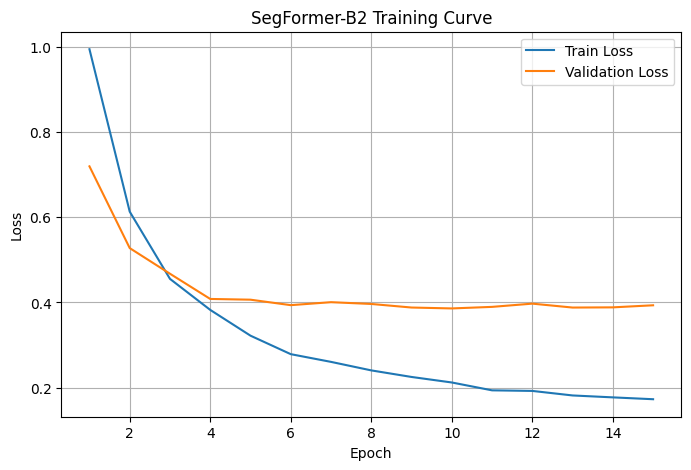

In [14]:
import pandas as pd

history = pd.read_csv(csv_path)

plt.figure(figsize=(8,5))
plt.plot(history["epoch"], history["train_loss"], label="Train Loss")
plt.plot(history["epoch"], history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SegFormer-B2 Training Curve")
plt.legend()
plt.grid(True)
plt.show()


<div class="alert alert-block alert-info">

----------
---------
# <b> 14. Saving Test Predictions</b> 

--------------
----------------
</div>

In [ ]:
import os
from PIL import Image
import numpy as np
import torch

# Path: segmentation_resnet/outputs/predictions/segformer_b2_predictions/
pred_dir = "../outputs/predictions/segformer_b2_predictions"
os.makedirs(pred_dir, exist_ok=True)

print("Saving predictions to:", pred_dir)

model.eval()

with torch.no_grad():
    for idx, (imgs, masks) in enumerate(test_loader):
        imgs = imgs.to(DEVICE)

        outputs = model(pixel_values=imgs).logits

        outputs = torch.nn.functional.interpolate(
            outputs,
            size=(512, 512),
            mode="bilinear",
            align_corners=False
        )

        preds = (torch.sigmoid(outputs) > 0.5).float().cpu().numpy()[0, 0]         # Converting to binary mask

        pred_img = (preds * 255).astype(np.uint8)         # Converting to image
        pred_pil = Image.fromarray(pred_img)

        img_path = test_dataset.items[idx][0]         # Extracting original filename from test_dataset
        base_name = os.path.basename(img_path)
        base_no_ext = os.path.splitext(base_name)[0]

        save_path = os.path.join(pred_dir, f"{base_no_ext}_pred.png")         # Saving as: <original_name>_pred.png
        pred_pil.save(save_path)

print("All predictions saved successfully! 🎉")


Saving predictions to: ../outputs/predictions/segformer_b2_predictions
All predictions saved successfully! 🎉
